In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%load_ext autoreload
%autoreload 2
from base_model1 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
x = Base_Model(data_size=900, cycles=80)
x.run()

Language model saved and vocab dumpped
Run one epoch with lower layers


Run for many epochs with all layers unfrozen


KeyboardInterrupt: ignored

In [0]:
from fastai import *
from fastai.text import *
#from pathlib import Path
import pandas as pd
import numpy as np
#import re

In [0]:
train = pd.read_csv('data_love_fam.csv')
train = pd.DataFrame(train['Poem'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 1 columns):
Poem    1496 non-null object
dtypes: object(1)
memory usage: 11.8+ KB


In [0]:
#transfer learning from UMLFit
nrows, ncols = train.shape
train_size = math.floor(nrows * 0.8)
data_lm = TextLMDataBunch.from_df('.', train.iloc[:train_size], train.iloc[train_size:], text_cols=['Poem'], min_freq=1)
data_lm.save('lm_databunch_sonnet')
#pickle.dump(data_lm.vocab.itos, open('vocab_love.pkl', 'wb'))
print ("Language model saved and vocab dumped")

Language model saved and vocab dumpped


In [0]:
#run the language_model_learner class
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)
print ("Run one epoch with lower layers")
learn.fit_one_cycle(cyc_len=1, max_lr=1e-1, moms=(0.8, 0.7))
print ("Run for many epochs with all layers unfrozen")
learn.unfreeze() 
learn.fit_one_cycle(cyc_len=30, max_lr=1e-1, moms=(0.8, 0.7))
learn.save('ft_love')
learn.save_encoder('ft_enc_love')
#torch.save(learn.model, 'finetuned_love.pth')
print ("Encoder saved and weights dumpped")


Run one epoch with lower layers


epoch,train_loss,valid_loss,accuracy,time
0,6.014570,5.323508,0.189392,00:46


Run for many epochs with all layers unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,5.076503,5.013712,0.205400,00:54
1,4.894094,5.116149,0.201903,00:54
2,4.891754,5.167446,0.202732,00:54
3,4.953993,5.343714,0.194632,00:54
4,5.086785,5.452847,0.190561,00:54
5,6.471387,6.669869,0.067804,00:53
6,6.739645,6.626711,0.036777,00:53
7,7.311350,7.344732,0.035278,00:53
8,11.877212,8.912408,0.058408,00:52
9,12.833594,8.765814,0.064658,00:52


KeyboardInterrupt: ignored

In [0]:
#test
TEXT = "In the hot blazing sun"
N_WORDS = 200
poem = (learn.predict(TEXT, N_WORDS, temperature = 0.7))
print (poem)

## Training a Song Generator with *ULMFiT*

Let's start with a quick end-to-end example of training a model. We'll train a song generator, showing 4 steps:

1. Reading and viewing the songdata
1. Getting your data ready for modeling
1. Fine-tuning a language model

More detailed notebook: https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb

In [0]:
from fastai.text import * 

Contrary to images in Computer Vision, text can't directly be transformed into numbers to be fed into a model. The first thing we need to do is to preprocess our data so that we change the raw texts to lists of words, or tokens (a step that is called tokenization) then transform these tokens into numbers (a step that is called numericalization). These numbers are then passed to embedding layers that will convert them in arrays of floats before passing them through a model.

Steps:

1. Get your data preprocessed and ready to use,
1. Create a language model with pretrained weights that you can fine-tune to your dataset

Now, we will import our song lyrics data from kaggle

In [0]:
import json
import zipfile
import os
#import kaggle

OSError: ignored

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "febriy" # username from the json file 
os.environ['KAGGLE_KEY'] = "38eb10cfc0a96aa36bae3e2f6fd1b329" # key from the json file
!kaggle datasets download -d mousehead/songlyrics # api copied from kaggle

401 - Unauthorized


Unzipping file:

In [0]:
!unzip songlyrics.zip -y

unzip:  cannot find or open songlyrics.zip, songlyrics.zip.zip or songlyrics.zip.ZIP.


## Open songdata

In [0]:
df = pd.read_csv('drive/My Drive/songdata.csv')

In [0]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


Now, let's get rid of any row with na value

In [0]:
df = df.dropna()
df.shape

(57650, 4)

We only want the text for now:

In [0]:
df = df.drop (columns=["artist","song","link"])

Choose only a portion of dataset

In [0]:
df = df[:1000]

In [0]:
df.shape

(1000, 1)

In [0]:
df.head()

,text
0,"Look at her face, it's a wonderful face \nAnd..."
1,"Take it easy with me, please \nTouch me gentl..."
2,I'll never know why I had to go \nWhy I had t...
3,Making somebody happy is a question of give an...
4,Making somebody happy is a question of give an...


In [0]:
# interject: training using shakedpeare sonnets
df = pd.read_csv('sonnets.txt', delimiter=" /s ", header=None)
df.columns = ["text"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [0]:
df.head()

,text
0,"From fairest creatures we desire increase,"
1,"That thereby beauty's rose might never die,"
2,"But as the riper should by time decease,"
3,His tender heir might bear his memory:
4,"But thou contracted to thine own bright eyes,"


## Train a language model
A language model is able to predict next word given a particular input word. For the transfer learning, we start with a pre-trained model that was trained on Wikipedia dataset. 

Here, we will use our song lyrics to re-train the model, enabling it to hopefully be able to compose songs!

### Create [DataBunch](https://medium.com/@tmckenzie.nz/using-the-fastai-data-block-api-b4818e72155b), which is the data-containing object we need to feed the neural network 

Load dataset in Language Model form

In [0]:
nrows, ncols = df.shape
train_size = math.floor(nrows * 0.8)
data_lm = TextLMDataBunch.from_df('.', df.iloc[:train_size], df.iloc[train_size:], text_cols=['text'])
data_lm

TextLMDataBunch;

Train: LabelList (1725 items)
x: LMTextList
xxbos xxmaj from fairest xxunk we desire increase ,,xxbos xxmaj that thereby beauty 's rose might never die ,,xxbos xxmaj but as the riper should by time decease ,,xxbos xxmaj his tender heir might bear his memory :,xxbos xxmaj but thou contracted to thine own bright eyes ,
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (432 items)
x: LMTextList
xxbos xxmaj as subject to xxmaj time 's love or to xxmaj time 's hate ,,xxbos xxmaj weeds xxunk weeds , or flowers with flowers xxunk .,xxbos xxmaj no , it was xxunk far from xxunk ;,xxbos xxmaj it xxunk not in xxunk xxunk , nor xxunk,xxbos xxmaj under the xxunk of xxunk xxunk ,
y: LMLabelList
,,,,
Path: .;

Test: None

In [0]:
data_lm.show_batch()

idx,text
0,"where abundance lies , xxbos xxmaj thy self thy xxunk , to thy sweet self too cruel : xxbos xxmaj thou that art now the world 's fresh ornament , xxbos xxmaj and only xxunk to the xxunk spring , xxbos xxmaj within thine own bud xxunk thy content , xxbos xxmaj and , tender churl , mak'st waste in xxunk : xxbos xxmaj pity the world , or else"
1,"whose xxunk womb xxbos xxmaj xxunk the xxunk of thy husbandry ? xxbos xxmaj or who is he so fond will be the tomb xxbos xxmaj of his self - love , to stop posterity ? xxbos xxmaj thou art thy mother 's glass and she in thee xxbos xxmaj calls back the lovely xxmaj april of her prime ; xxbos xxmaj so thou through windows of thine age shalt"
2,"xxmaj to hideous winter , and confounds him there ; xxbos xxmaj sap checked with xxunk , and lusty leaves quite gone , xxbos xxmaj beauty o'er - xxunk and bareness every where : xxbos xxmaj then were not summer 's xxunk left , xxbos a xxunk xxunk xxunk in xxunk of glass , xxbos xxmaj beauty 's effect with beauty were xxunk , xxbos xxmaj nor it , nor"
3,"up heavenly xxunk , xxbos xxmaj resembling strong youth in his xxunk age , xxbos xxmaj yet mortal looks xxunk his beauty still , xxbos xxmaj attending on his golden pilgrimage : xxbos xxmaj but when from xxunk pitch , with weary xxunk , xxbos xxmaj like xxunk age , he xxunk from the day , xxbos xxmaj the eyes , ' fore xxunk , now converted are xxbos xxmaj"
4,"; xxbos xxmaj the world will be thy widow and still weep xxbos xxmaj that thou no form of thee hast left behind , xxbos xxmaj when every xxunk widow well may keep xxbos xxmaj by children 's eyes , her husband 's shape in mind : xxbos xxmaj look what an xxunk in the world doth spend xxbos xxmaj xxunk but his place , for still the world xxunk"


Let's save our databunch for next time:

In [0]:
data_lm.save('lm_databunch_sonnets')

Note that you can load the data with different [`DataBunch`](/basic_data.html#DataBunch) parameters (batch size, `bptt`,...)

### Loading saved data, and creating the language model

We can use the `data_lm` object we created earlier to fine-tune a pretrained language model. [fast.ai](http://www.fast.ai/) has an English model with an AWD-LSTM architecture available that we can download. We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning.

In [0]:
bs = 192
path = Path('.')

In [0]:
data_lm = load_data(path, 'lm_databunch_sonnets', bs=bs)

We can add this dataset into a learner object with a model loaded with the pretrained weight. 

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

Extra: we can print the structure of the language model RNN

In [0]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(1160, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(1160, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=1160, bias=True)
   (output_dp): RNNDropout()
 )]

### Find the optimum learning rate

What is the learning rate? It is the distance/ steps change of model parameter every epoch. 

You don't want a learning rate that is too big, because you might miss the best point. You don't wanr a learning rate that is too small, because you'll take too long to train.

We will use fastai's learning rate finder. Choose something when the loss is still decreasing. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


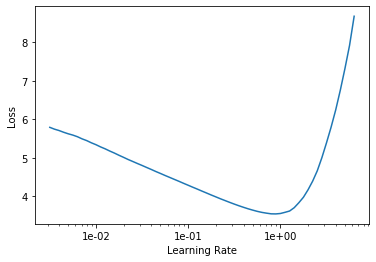

In [0]:
learn.lr_find(start_lr=1e-3, end_lr=1e2)
learn.recorder.plot()

### Run the language_model_learner class

In [0]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.982650,5.248903,0.214583,00:00


### Unfreeze the entire model
To complete the fine-tuning, we can then unfreeze the model and fine-tune it.

In [0]:
learn.unfreeze()

Fit for 20 epoch:

In [0]:
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.157040,3.721456,0.306399,00:00
1,3.171857,3.721968,0.305283,00:00
2,3.159294,3.731735,0.302976,00:00
3,3.146991,3.741076,0.308631,00:00
4,3.117488,3.781140,0.294494,00:00
5,3.079603,3.807837,0.302753,00:00
6,3.035048,3.873974,0.290030,00:00
7,2.989988,3.876708,0.285119,00:00
8,2.947263,3.898700,0.299702,00:00
9,2.916405,4.022411,0.273958,00:00


To evaluate your language model, you can run the [`Learner.predict`](/basic_train.html#Learner.predict) method and specify the number of words you want it to guess.

In [0]:
TEXT = "thou art my enemy"
N_WORDS = 50

In [0]:
poem = learn.predict(TEXT, N_WORDS, temperature = 0.75)
print (poem)

thou art my enemy and errors make turns ? xxbos So fair a fool is love , that thus is my love . xxbos Than those old lovers ' loves , that you do know xxbos Within the knowledge of mine own desert , xxbos To me that you are


thou art my enemy and the beauties ' faces xxbos And for my sake only love seem false , xxbos And my sweet flower again be sweet , xxbos Having no influence upon thy heart , xxbos And she in thee holds a prize : xxbos That with men


See the effect of temperature above. A higher temperature value makes the song more 'creative' and less repetitive

The song generated might not make much sense (we have a tiny vocabulary here and didn't train much on it) but note that it respects basic grammar (which comes from the pretrained model).

Finally we save the encoder to be able to use it for classification in the next section.

In [0]:
learn.save('fine_tuned_20')
learn.save_encoder('fine_tuned_enc_20')

What have we done? We have re-trained a language model initially trained on Wikipedia to now be able to produce tweets. 

We will use this language model to build a classifier next. 

### Next: Building a classifier
Perhaps we can build a classifier that can differentiate between different artists?

## Testing to load trained model

In [0]:
bs = 192
path = Path('.')

In [0]:
data_lm = load_data(path, 'lm_databunch', bs=bs)

In [0]:
learntest = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learntest.load_encoder ('fine_tuned_enc_20')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (800 items)
x: LMTextList
xxbos xxmaj look at her face , it 's a wonderful face 
  xxmaj and it means something special to me 
  xxmaj look at the way that she smiles when she sees me 
  xxmaj how lucky can one fellow be ? 
 
  xxmaj she 's just my kind of girl , she makes me feel fine 
  xxmaj who could ever believe that she could be mine ? 
  xxmaj she 's just my kind of girl , without her i 'm blue 
  xxmaj and if she ever leaves me what could i do , what could i do ? 
 
  xxmaj and when we go for a walk in the park 
  xxmaj and she holds me and xxunk my hand 
  xxmaj we 'll go on walking for hours and talking 
  xxmaj about all the things that we plan 
 
  xxmaj she 's just my kind of girl , she makes me feel fine 
  xxmaj who could ever believe that she could be mine ? 
  xxmaj she 's just my kind of girl , without her i 'm blue 
  xxmaj and if she ever leaves me what could i do , what could i do ? 
 
 ,xxbos xxmaj take it ea

In [0]:
TEXT = "we are learning transfer learning"
N_WORDS = 50

In [0]:
poem = learntest.predict(TEXT, N_WORDS, temperature = 0.75)
print(poem)

we are learning transfer learning 
  In our care 
  There 's only one so able 
  Could anyone believe 
  To be understood and advised 
  To step closer than the ones to our land 
  As we walk away 
  As we walk away 
 


In [0]:
poem

"we are learning transfer learning \n  In our care \n  There 's only one so able \n  Could anyone believe \n  To be understood and advised \n  To step closer than the ones to our land \n  As we walk away \n  As we walk away \n "

In [0]:
!pip install gtts

  Created wheel for gtts-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4097 sha256=1b5037e2e6f6acfc04fd79d74ad3898e2b83b6ea6cb3398167eb523819fbbfb3
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts-token


In [0]:
from gtts import gTTS
import os
tts = gTTS(text=poem, lang='en')
tts.save("good.mp3")
os.system("mpg321 good.mp3")

32512

In [0]:
tts = gTTS(poem, lang='en')
tts.save('poem.wav')

In [0]:
import pickle

In [0]:
DATAPATH = '.'

In [0]:
data_lm.vocab.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '\n ',
 'i',
 'the',
 ',',
 'you',
 '\n \n ',
 'to',
 'and',
 'a',
 'it',
 'me',
 "'s",
 "n't",
 'in',
 'my',
 'of',
 'that',
 'do',
 'we',
 'your',
 'on',
 'all',
 'love',
 "'",
 'is',
 'be',
 "'m",
 'for',
 'so',
 "'re",
 'when',
 'just',
 '.',
 'but',
 '-',
 'with',
 'know',
 'no',
 'got',
 'there',
 '(',
 ')',
 'can',
 "'ll",
 'if',
 'like',
 'what',
 'now',
 'one',
 'was',
 'down',
 'she',
 'time',
 "'ve",
 'are',
 'na',
 'never',
 'see',
 'this',
 'have',
 'he',
 'up',
 'out',
 'go',
 'oh',
 'let',
 'get',
 'ca',
 'take',
 'want',
 'they',
 'baby',
 'come',
 'will',
 'at',
 'away',
 'as',
 'gon',
 'say',
 'way',
 'more',
 'not',
 '?',
 'here',
 'from',
 'yeah',
 'could',
 'make',
 'night',
 'day',
 'how',
 'too',
 'tell',
 'where',
 'life',
 'heart',
 'feel',
 'her',
 'man',
 'through',
 'back',
 'by',
 'give',
 'little',
 'only',
 'need',
 'our',
 'chorus',
 "'d",
 'right',
 'la',
 'been',

In [0]:
pickle.dump(data_lm.vocab.itos, open('vocab.pkl', 'wb'))

In [0]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(4360, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(4360, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=4360, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:
torch.save(learn.model, 'fine_tuned_enc_20.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SequentialRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AWD_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type EmbeddingDropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local

In [0]:
import dill as dill
torch.save(learn.model, 'fine_tuned_enc_20_2.pth', pickle_module=dill)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SequentialRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AWD_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type EmbeddingDropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local

In [0]:
!pip3 install torchvision

     |████████████████████████████████| 773.1MB 21kB/s 
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [0]:
import torch
from fastai import *

In [0]:
model = torch.load('fine_tuned_enc_20.pth')
model.eval()

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(4360, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(4360, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=4360, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:
infile = open('vocab.pkl', 'rb')
data_lm = pickle.load(infile)
infile.close()

In [0]:
TEXT = "we are learning transfer learning"
N_WORDS = 50

In [0]:
poem = model.predict(TEXT, N_WORDS, temperature = 0.75)
print(poem)

AttributeError: ignored